#### This notebook shows how to read the fastMRI dataset and apply some simple transformations to the data.

Imports :

In [109]:
%matplotlib inline

import h5py
import numpy as np
from matplotlib import pyplot as plt

Our dataset is distributed as a set of HDF5 files and can be read with the h5py package. Each file corresponds to one MRI scan and contains the k-space data, ground truth and some meta data related to the scan.
Our files are is /volatile/FastMRI/brain_multicoil_train/multicoil_train . 

In [110]:
file_path = "/volatile/FastMRI/brain_multicoil_train/multicoil_train/file_brain_AXT1POST_201_6002746.h5"
hf = h5py.File(file_path)

In [111]:
print('Keys:', list(hf.keys()))
print('Attrs:', dict(hf.attrs))

Keys: ['ismrmrd_header', 'kspace', 'reconstruction_rss']
Attrs: {'acquisition': 'AXT1POST', 'max': 0.0008215667017516178, 'norm': 0.15971065850506472, 'patient_id': '03f0ca72cb9c5382c4d6d8a34d966a1efcb2168d504e7dda2b69a8894b960fc2'}


In multi-coil MRIs, k-space has the following shape:
(number of slices, number of coils, height, width)

For single-coil MRIs, k-space has the following shape:
(number of slices, height, width)

MRIs are acquired as 3D volumes, the first dimension is the number of 2D slices.

In [112]:
volume_kspace = hf['kspace'][()]
print(volume_kspace.dtype)
print(volume_kspace.shape)

complex64
(16, 16, 640, 320)


In [113]:
slice_kspace = volume_kspace[volume_kspace.shape[0]-1] # Choosing the lastest slice of this volume

Let's see what the absolute value of k-space looks like:

In [114]:
def show_coils(data, slice_nums, cmap=None):
    fig = plt.figure()
    for i, num in enumerate(slice_nums):
        plt.subplot(1, len(slice_nums), i + 1)
        plt.imshow(data[num], cmap=cmap)

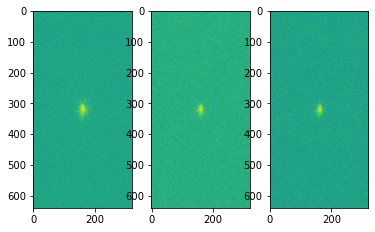

In [115]:
# This shows coils 0, 5 and 10
show_coils(np.log(np.abs(slice_kspace) + 1e-9), [0, 5, 10]) 

# # This show all  the coils
num_coils = slice_kspace.shape[0] # number of coils in the k-space

# for coil_index in range(num_coils):
#     show_coils(np.log(np.abs(slice_kspace) + 1e-9), [coil_index])

The fastMRI repo contains some utlity functions to convert k-space into image space. These functions work on PyTorch Tensors. The to_tensor function can convert Numpy arrays to PyTorch Tensors.

In [116]:
import fastmri
from fastmri.data import transforms as T

In [117]:
slice_kspace2 = T.to_tensor(slice_kspace)      # Convert from numpy array to pytorch tensor
slice_image = fastmri.ifft2c(slice_kspace2)           # Apply Inverse Fourier Transform to get the complex image
slice_image_abs = fastmri.complex_abs(slice_image)   # Compute absolute value to get a real image

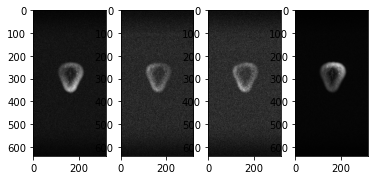

In [120]:
show_coils(slice_image_abs, [0, 5, 10, 15], cmap='gray') 
# for coil_index in range(num_coils):
#     show_coils(np.log(np.abs(slice_image_abs) + 1e-9), [coil_index], cmap='gray')

As we can see, each coil in a multi-coil MRI scan focusses on a different region of the image. These coils can be combined into the full image using the Root-Sum-of-Squares (RSS) transform, it call single-coil image.

In [121]:
new_image_singlecoil = fastmri.coil_combine.virtual_coil_reconstruction(slice_image_abs)
print(new_image_singlecoil)

AttributeError: module 'fastmri.coil_combine' has no attribute 'virtual_coil_reconstruction'

In [ ]:
slice_image_rss = fastmri.rss(slice_image_abs, dim=0)
# print(slice_image_rss)

And of this , we get one image with all the informations of the previous one.

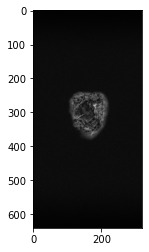

In [ ]:
plt.imshow(np.abs(slice_image_rss.numpy()), cmap='gray')

So far, we have been looking at fully-sampled data. We can simulate under-sampled data by creating a mask and applying it to k-space.

In [ ]:
from fastmri.data.subsample import RandomMaskFunc
mask_func = RandomMaskFunc(center_fractions=[0.04], accelerations=[8])  # Create the mask function object

In [ ]:
masked_kspace, mask, _ = T.apply_mask(slice_kspace2, mask_func)   # Apply the mask to k-space

Let's see what the subsampled image looks like:

In [ ]:
sampled_image = fastmri.ifft2c(masked_kspace)           # Apply Inverse Fourier Transform to get the complex image
sampled_image_abs = fastmri.complex_abs(sampled_image)   # Compute absolute value to get a real image
sampled_image_rss = fastmri.rss(sampled_image_abs, dim=0)

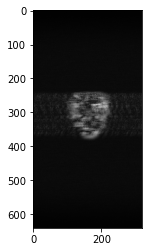

In [ ]:
plt.imshow(np.abs(sampled_image_rss.numpy()), cmap='gray')